# Caso práctico con el Modelo AquaCrop
## Festival de riego tecnificado
### Ing. Ag. Marcelo Bueno Dueñas


<a href="https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


## Google Colab

Si no estás familiarizado con Jupyter Notebooks o Google Colab, <a href="https://colab.research.google.com/notebooks/intro.ipynb">aquí</a> tienes un cuaderno introductorio para comenzar. En resumen, estos son documentos  que te permiten combinar bloques de texto como este (incluyendo html, LaTeX, etc.) con bloques de código que puedes escribir, editar y ejecutar. Para ejecutar el código en cada celda, haz clic en el botón de ejecución en la esquina superior izquierda de la celda o presiona SHIFT-ENTER cuando la celda esté seleccionada. También puedes navegar por el documento usando la tabla de contenido en el lado izquierdo.



<a id='Imports'><a/>

## Imports





Para usar AquaCrop dentro de este notebook, primero necesitamos instalarlo e importarlo. Instalar aquacrop es tan sencillo como ejecutar `pip install aquacrop` o `!pip install aquacrop==VERSION` para instalar una versión específica. En la celda de abajo también usamos la función 'output.clear' para mantener todo ordenado.



In [1]:
!pip install aquacrop

from google.colab import output
output.clear()



En caso de que la instalación mediante 'pip' falle por cualquier motivo, puedes instalar directamente desde GitHub usando la celda de abajo.

In [2]:
# !pip install git+https://github.com/aquacropos/aquacrop

# from google.colab import output
# output.clear()



Ahora que `aquacrop` está instalado, necesitamos importar los diversos componentes en el notebook. No es necesario importar todas estas funciones de una sola vez como lo hemos hecho en la celda de abajo, pero ayudará a mantener todo más claro a lo largo de este cuaderno.


In [3]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, FieldMngt, GroundWater, IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

#  Componentes del modelo

Ejecutar un modelo de AquaCrop requiere la selección de 5 componentes:

1.   Mediciones climáticas
3.   Selección del suelo
4.   Selección del cultivo
5.   Contenido inicial de agua
1.   Fechas de inicio y fin de la simulación

A continuación, revisaremos la selección de estos componentes uno por uno.



## Clima

AquaCrop requiere que los datos meteorológicos estén especificados para todo el periodo de cultivo que se va a simular. Esto incluye una serie temporal diaria de temperaturas mínimas y máximas [C], precipitación
[mm] y evapotranspiración de referencia del cultivo [mm].


Para cargar los datos meteorológicos en el modelo, utiliza la función `prepare_weather`, pasando la ruta del archivo .txt. Esta función `prepare_weather` creará un DataFrame de pandas en Python que almacenará los datos meteorológicos importados en el formato correcto para las simulaciones posteriores.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


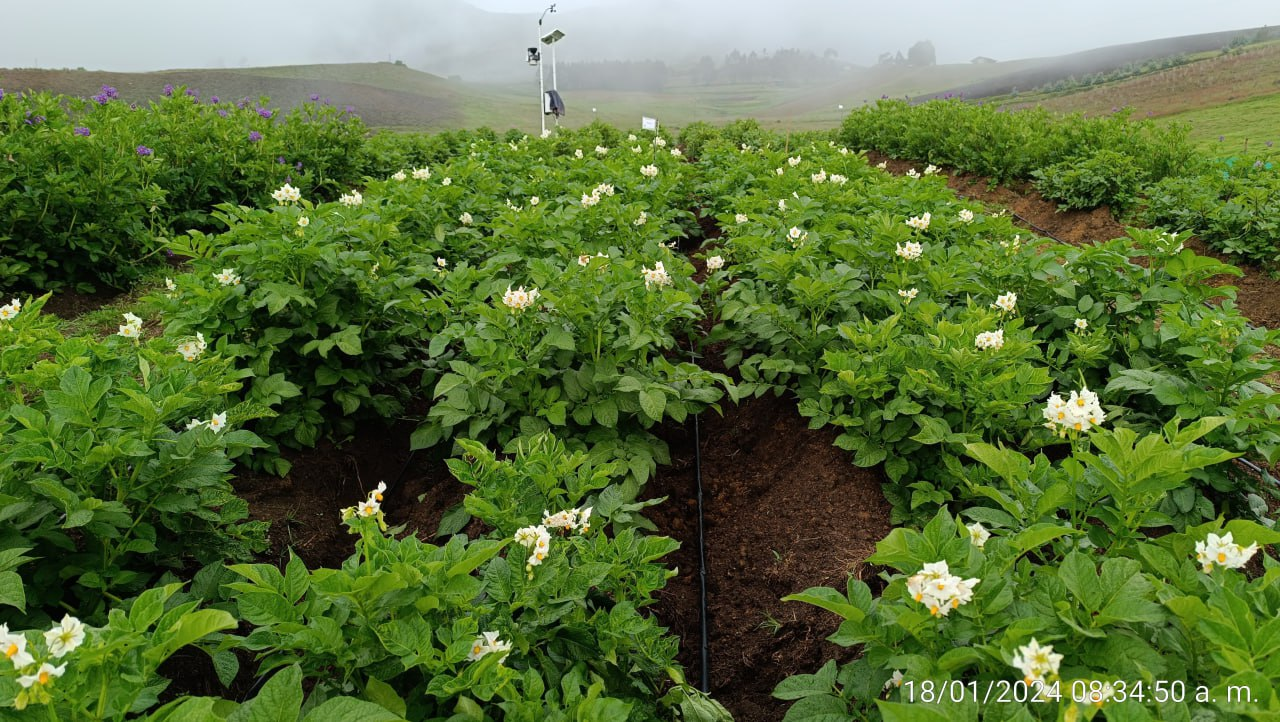

In [5]:
Image('/content/drive/MyDrive/aquacrop/figurs/met.png')

In [6]:
# specify filepath to weather file (either locally or imported to colab)
# Use the get_filepath function to access the built-in weather file
filepath = get_filepath('/content/drive/MyDrive/aquacrop/aquacrop_py/clim_chugay_2022.txt')
weather_data = prepare_weather(filepath)
weather_data

MinTemp    MaxTemp  Precipitation  ReferenceET       Date
0    10.055385  10.356923       0.000000         1.30 2022-07-11
1     8.003472   8.306944       0.000000         2.48 2022-07-12
2     7.698611   8.023611       0.000000         2.53 2022-07-13
3     8.261806   8.568750       0.000000         3.12 2022-07-14
4     8.526389   8.854861       0.000000         3.01 2022-07-15
..         ...        ...            ...          ...        ...
696   7.239583   7.950000       0.143936         2.11 2024-07-12
697   7.772917   8.341667       0.000000         2.56 2024-07-13
698   7.877083   8.539583       0.000000         2.66 2024-07-14
699   7.385417   8.020833       0.000000         3.24 2024-07-15
700   7.878378   8.608108       0.000000         4.17 2024-07-16

[701 rows x 5 columns]

Podemos editar la información de clima de ser necessrio

In [7]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=weather_data)

Un gráfico simple de las series de tiempo

In [8]:

def plot_weather(weather_data, start_date=None, end_date=None):
    # Ensure Date column exists
    if 'Date' not in weather_data.columns:
        weather_data['Date'] = pd.date_range(start='1981-01-01', periods=len(weather_data))

    # Filter by date range if specified
    if start_date and end_date:
        mask = (weather_data['Date'] >= pd.to_datetime(start_date)) & (weather_data['Date'] <= pd.to_datetime(end_date))
        weather_data = weather_data.loc[mask]

    # Define variables, colors, titles
    variables = ['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET']
    colors = ['blue', 'red', 'skyblue', 'orange']
    titles = ['Minimum Temperature [°C]', 'Maximum Temperature [°C]', 'Precipitation [mm]', 'Reference ET [mm]']

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

    for i, (var, color, title) in enumerate(zip(variables, colors, titles)):
        ax = axs[i // 2, i % 2]
        ax.plot(weather_data['Date'], weather_data[var], color=color, linewidth=0.8)
        ax.set_title(title)
        ax.set_ylabel(title.split()[0])
        ax.set_xlabel('Date')
        ax.tick_params(axis='x', rotation=45)

    fig.suptitle('Daily Weather Variables', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


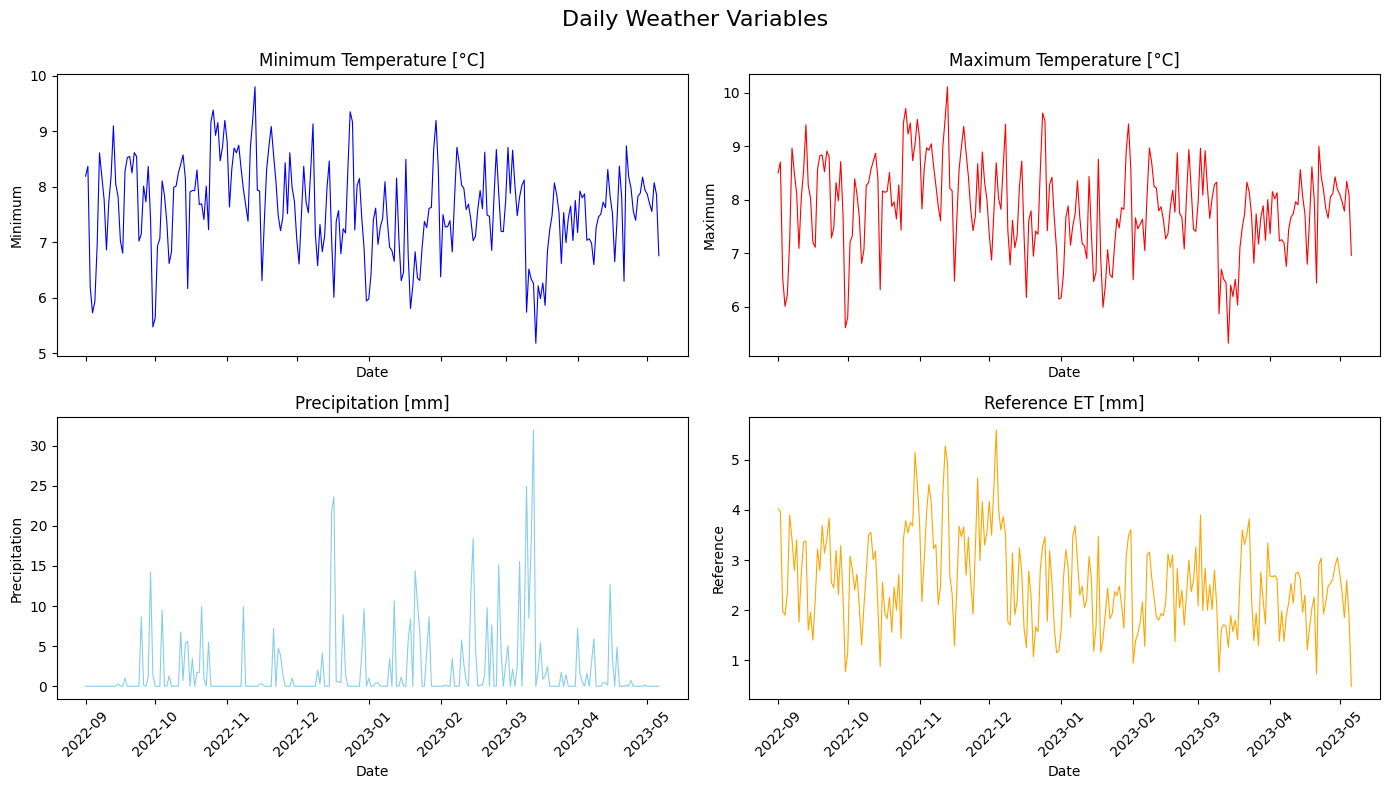

In [9]:
plot_weather(weather_data, start_date='2022-09-01', end_date='2023-05-31')

## Suelo


La selección de un tipo de suelo para una simulación en AquaCrop se realiza mediante el objeto `Soil`. Este objeto contiene todas las propiedades  hidráulicas necesarias para la simulación. La forma más sencilla de seleccionar un `Soil` es utilizar uno de los tipos de suelo incorporados, tomados de los valores predeterminados de AquaCrop. Una representación visual de estos valores predeterminados se muestra a continuación.

![picture](https://drive.google.com/uc?export=view&id=11CDRTYgYrYxsQyEwih_0jDAozIu_l-ak)

Como ejemplo, para seleccionar un suelo de tipo 'ClayLoam', ejecuta la celda a continuación.

El usuario puede editar cualquiera de estos tipos de suelo predeterminados o crear su propio perfil de suelo personalizado.

In [10]:
FRANCO_ARCILLOSO = Soil(soil_type='ClayLoam')
FRANCO = Soil(soil_type='Loam')
FRANCO_ARCILLOSO_ARENOSO = Soil(soil_type='SandyClayLoam')

FRANCO_ARCILLOSO_ARENOSO.profile

Comp  Layer   dz  dzsum  zBot  z_top  zMid  th_dry  th_wp  th_fc  th_s  \
0      0    1.0  0.1    0.1   0.1    0.0  0.05     0.1    0.2   0.32  0.47   
1      1    1.0  0.1    0.2   0.2    0.1  0.15     0.1    0.2   0.32  0.47   
2      2    1.0  0.1    0.3   0.3    0.2  0.25     0.1    0.2   0.32  0.47   
3      3    1.0  0.1    0.4   0.4    0.3  0.35     0.1    0.2   0.32  0.47   
4      4    1.0  0.1    0.5   0.5    0.4  0.45     0.1    0.2   0.32  0.47   
5      5    1.0  0.1    0.6   0.6    0.5  0.55     0.1    0.2   0.32  0.47   
6      6    1.0  0.1    0.7   0.7    0.6  0.65     0.1    0.2   0.32  0.47   
7      7    1.0  0.1    0.8   0.8    0.7  0.75     0.1    0.2   0.32  0.47   
8      8    1.0  0.1    0.9   0.9    0.8  0.85     0.1    0.2   0.32  0.47   
9      9    1.0  0.1    1.0   1.0    0.9  0.95     0.1    0.2   0.32  0.47   
10    10    1.0  0.1    1.1   1.1    1.0  1.05     0.1    0.2   0.32  0.47   
11    11    1.0  0.1    1.2   1.2    1.1  1.15     0.1    0.2   0.32  0.47   

     Ksat  penetrability   tau  
0   225.0          100.0  0.58  
1   225.0          100.0  0.58  
2   225.0          100.0  0.58  
3   225.0          100.0  0.58  
4   225.0          100.0  0.58  
5   225.0          100.0  0.58  
6   225.0          100.0  0.58  
7   225.0          100.0  0.58  
8   225.0          100.0  0.58  
9   225.0          100.0  0.58  
10  225.0          100.0  0.58  
11  225.0          100.0  0.58

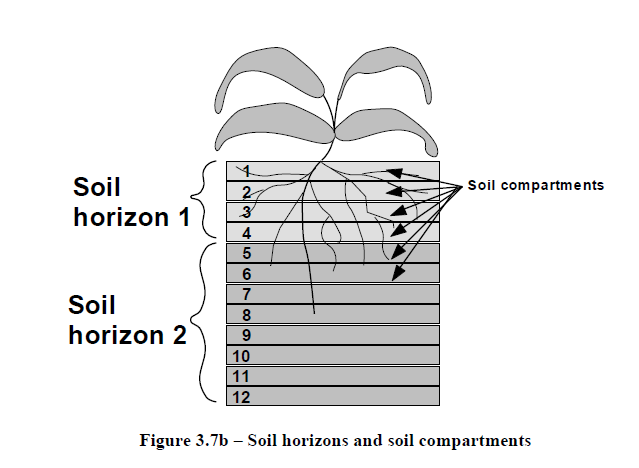

In [11]:
Image('/content/drive/MyDrive/aquacrop/figurs/perfil_discret.png')


# Suelo con datos de *laboratorio*


Se pueden crear clases de suelo personalizadas pasando 'custom' como tipo de suelo al crear un objeto `Soil`. En la celda siguiente se crea un suelo personalizado con un número de curva (CN=46) y agua fácilmente evaporable (REW=7). A continuación, se muestra una lista completa de los parámetros que se pueden especificar:


Variable Name | Description | Default
--- | --- | ---
soilType | Soil classification e.g. 'sandy_loam' | REQUIRED
dz | thickness of each soil compartment e.g. 12 compartments of thickness 0.1m | [0.1]*12
CalcSHP | Calculate soil hydraulic properties (0 = No, 1 = Yes) | 0
AdjREW | Adjust default value for readily evaporable water (0 = No, 1 = Yes) | 1
REW | Readily evaporable water (mm) | 9.0
CalcCN | Calculate curve number (0 = No, 1 = Yes) | 1
CN | Curve Number | 61.0
zRes | Depth of restrictive soil layer (negative value if not present) | -999
 | **Los parámetros que se muestran a continuación no deben modificarse sin conocimientos especializados.** |
EvapZsurf | Thickness of soil surface skin evaporation layer (m) | 0.04
EvapZmin | Minimum thickness of full soil surface evaporation layer (m) | 0.15
EvapZmax | Maximum thickness of full soil surface evaporation layer (m) | 0.30
Kex | Maximum soil evaporation coefficient | 1.1
fevap | Shape factor describing reduction in soil evaporation in stage 2. | 4
fWrelExp | Proportional value of Wrel at which soil evaporation layer expands | 0.4
fwcc | Maximum coefficient for soil evaporation reduction due to sheltering effect of withered canopy | 50
zCN | Thickness of soil surface (m) used to calculate water content to adjust curve number | 0.3
zGerm | Thickness of soil surface (m) used to calculate water content for germination | 0.3
AdjCN | Adjust curve number for antecedent moisture content (0: No, 1: Yes) | 1
fshape_cr | Capillary rise shape factor | 16
zTop | Thickness of soil surface layer for water stress comparisons (m) | 0.1




Las propiedades hidráulicas del suelo se especifican utilizando `.add_layer()`. Esta función requiere la profundidad de la capa del suelo [m] (solo la profundidad del perfil del suelo si se usa una sola capa), el contenido de agua en el Punto de Marchitez [m³/m³],  Capacidad de Campo [m³/m³] y Saturación [m³/m³], así como la conductividad hidráulica saturada [mm/día] y la penetrabilidad del suelo [%].

In [12]:
MI_SUELO = Soil('custom', cn=46, rew=7)

MI_SUELO.add_layer(thickness=0.4, thWP=0.2, thFC=0.32, thS=0.47, Ksat=180, penetrability=100)
MI_SUELO.add_layer(thickness=0.2, thWP=0.2, thFC=0.32, thS=0.47, Ksat=180,  penetrability=95)
MI_SUELO.add_layer(thickness=0.4, thWP=0.2, thFC=0.30, thS=0.47, Ksat=180,  penetrability=90)
MI_SUELO.add_layer_from_texture(thickness=0.2,
                              Sand=10,Clay=45,
                              OrgMat=2.5,penetrability=100)
MI_PERFIL=MI_SUELO.profile
MI_PERFIL


Comp  Layer   dz  dzsum  zBot  z_top  zMid  th_dry  th_wp  th_fc   th_s  \
0      0    1.0  0.1    0.1   0.1    0.0  0.05   0.100  0.200  0.320  0.470   
1      1    1.0  0.1    0.2   0.2    0.1  0.15   0.100  0.200  0.320  0.470   
2      2    1.0  0.1    0.3   0.3    0.2  0.25   0.100  0.200  0.320  0.470   
3      3    1.0  0.1    0.4   0.4    0.3  0.35   0.100  0.200  0.320  0.470   
4      4    2.0  0.1    0.5   0.5    0.4  0.45   0.100  0.200  0.320  0.470   
5      5    2.0  0.1    0.6   0.6    0.5  0.55   0.100  0.200  0.320  0.470   
6      6    3.0  0.1    0.7   0.7    0.6  0.65   0.100  0.200  0.300  0.470   
7      7    3.0  0.1    0.8   0.8    0.7  0.75   0.100  0.200  0.300  0.470   
8      8    3.0  0.1    0.9   0.9    0.8  0.85   0.100  0.200  0.300  0.470   
9      9    3.0  0.1    1.0   1.0    0.9  0.95   0.100  0.200  0.300  0.470   
10    10    4.0  0.1    1.1   1.1    1.0  1.05   0.134  0.268  0.409  0.523   
11    11    4.0  0.1    1.2   1.2    1.1  1.15   0.134  0.268  0.409  0.523   

     Ksat  penetrability   tau  
0   180.0          100.0  0.53  
1   180.0          100.0  0.53  
2   180.0          100.0  0.53  
3   180.0          100.0  0.53  
4   180.0           95.0  0.53  
5   180.0           95.0  0.53  
6   180.0           90.0  0.53  
7   180.0           90.0  0.53  
8   180.0           90.0  0.53  
9   180.0           90.0  0.53  
10   88.1          100.0  0.42  
11   88.1          100.0  0.42

Un gráfico simple del perfil

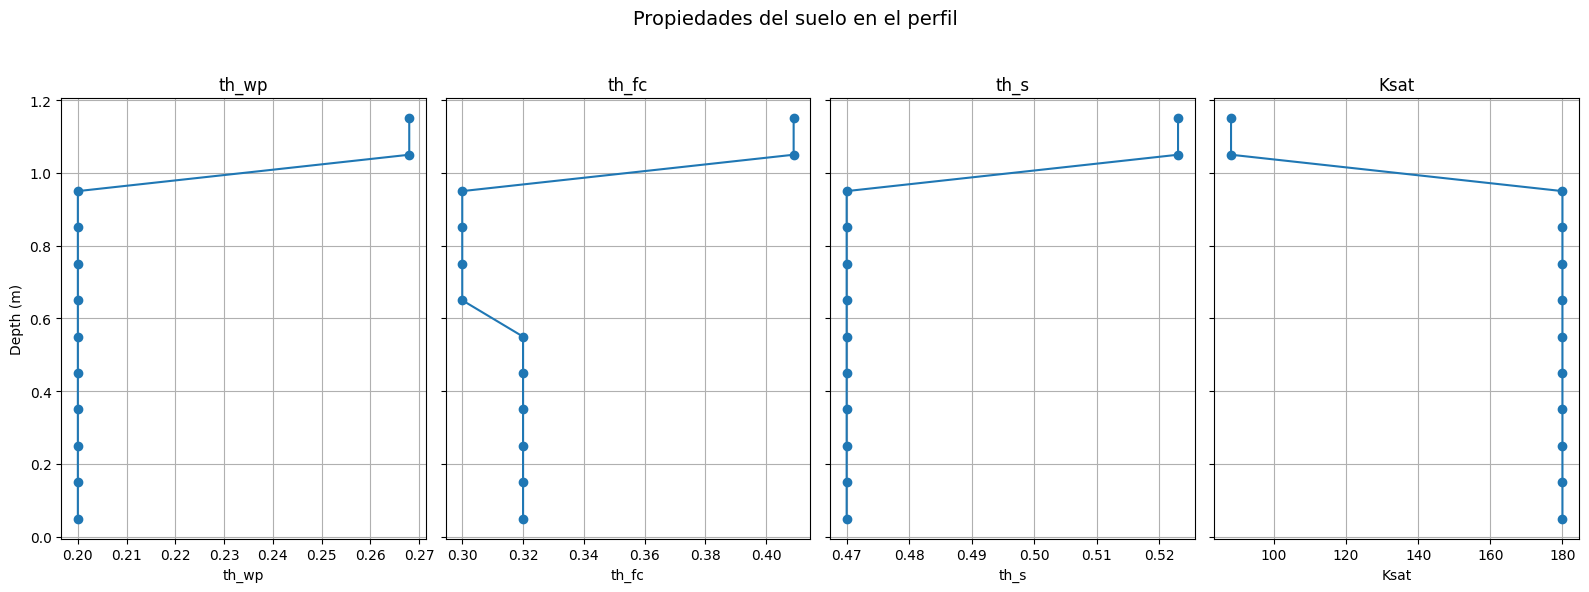

In [13]:
# Variables to plot
variables = ['th_wp', 'th_fc', 'th_s', 'Ksat']
depth = MI_PERFIL['zMid']  # Depth in meters

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

for i, var in enumerate(variables):
    axes[i].plot(MI_PERFIL[var], MI_PERFIL['zMid'], marker='o')
    axes[i].invert_yaxis()  # <- This makes 0 at top, 1.2 at bottom
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    if i == 0:
        axes[i].set_ylabel("Depth (m)")
    axes[i].grid(True)

plt.suptitle("Propiedades del suelo en el perfil", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


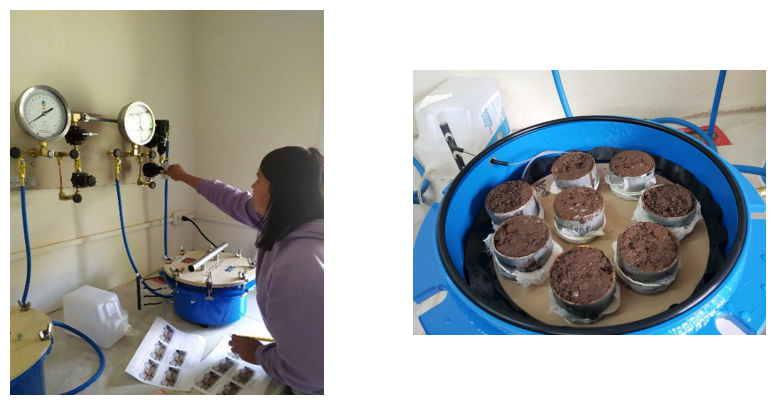

In [14]:
from IPython.display import Image, display

# display(
#     Image('/content/drive/MyDrive/aquacrop/ollas1.jpg', width=400),
#     Image('/content/drive/MyDrive/aquacrop/ollas2.jpg', width=400)
# )


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mpimg.imread('/content/drive/MyDrive/aquacrop/figurs/ollas1.jpg'))
ax[1].imshow(mpimg.imread('/content/drive/MyDrive/aquacrop/figurs/ollas2.jpg'))
for a in ax: a.axis('off')
plt.show()



## Cultivo


El tipo de cultivo utilizado en la simulación se selecciona de manera similar al suelo mediante el objeto 'Crop'. Para seleccionar un 'Crop', necesitas especificar el tipo de cultivo y la fecha de siembra. Cualquiera de los tipos de cultivo incorporados (actualmente Maíz, Trigo, Arroz, Papa) puede seleccionarse ejecutando la celda a continuación.


In [15]:
PAPA_PARCELA_1 = Crop('Potato',
                      planting_date='10/01',      # '11/01',
                      harvest_date='04/12',       #'05/30',
                      # Tbase=5,                    # Base temperature in °C
                      Zmin=0.2,                   # Minimum root depth [m]
                      Zmax=0.3,                   # Maximum root depth [m]
                      CC0 = 0 ,               # Canopy 90% emergence coefficient
                      CCx=0.90,                   # Maximum canopy cover
                      CGC=0.12,                 # Canopy growth coefficient
                      CDC=0.17,                 # Canopy decline coefficient
                      WP=15.0,                    # Water productivity [g/m2], C3
                      Kcb=1.1,                   # Basal crop coefficient
                      HI0 = 0.55,
                      # b_HI = 10
                      )

PAPA_PARCELA_1




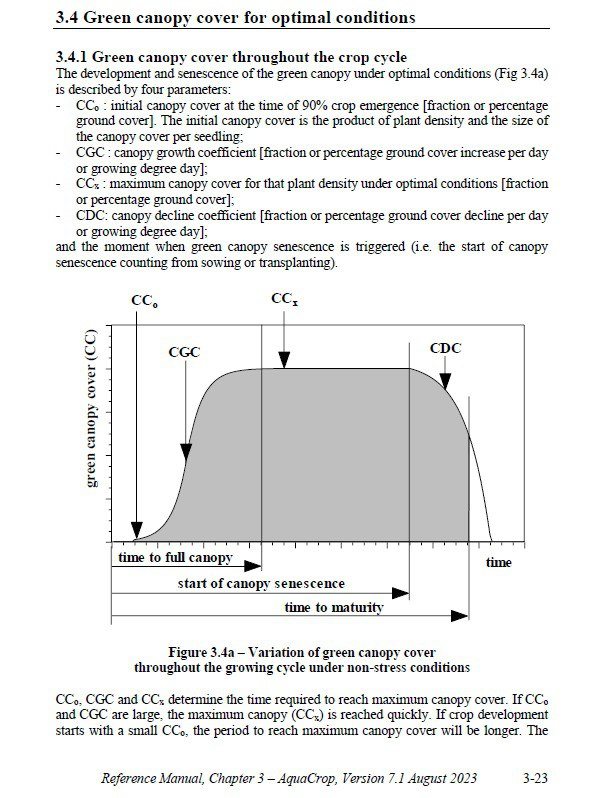

In [16]:
Image('/content/drive/MyDrive/aquacrop/figurs/crop_prms.png')

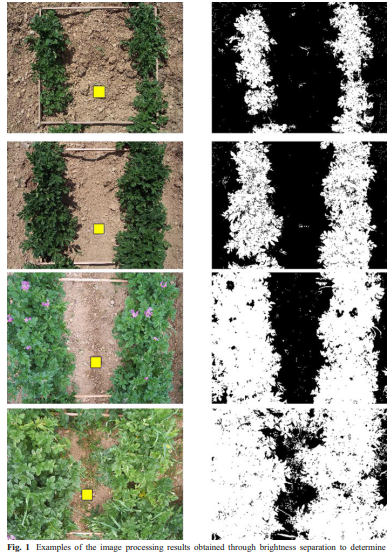

In [17]:
Image('/content/drive/MyDrive/aquacrop/figurs/cc_papa.PNG')

A continuación se muestra una lista completa de los parámetros del cultivo que se pueden modificar.

Variable Name | Default | Description
--- | --- | ---
Name | | Crop Name e.ge. 'maize'
CropType | | Crop Type (1 = Leafy vegetable, 2 = Root/tuber, 3 = Fruit/grain)
PlantMethod | | Planting method (0 = Transplanted, 1 =  Sown)
CalendarType | | Calendar Type (1 = Calendar days, 2 = Growing degree days)
SwitchGDD | | Convert calendar to GDD mode if inputs are given in calendar days (0 = No; 1 = Yes)
PlantingDate | | Planting Date (mm/dd)
HarvestDate | | Latest Harvest Date (mm/dd)
Emergence  | | Growing degree/Calendar days from sowing to emergence/transplant recovery
MaxRooting  | | Growing degree/Calendar days from sowing to maximum rooting
Senescence  | | Growing degree/Calendar days from sowing to senescence
Maturity  | | Growing degree/Calendar days from sowing to maturity
HIstart  | | Growing degree/Calendar days from sowing to start of yield formation
Flowering  | | Duration of flowering in growing degree/calendar days (-999 for non-fruit/grain crops)
YldForm  | | Duration of yield formation in growing degree/calendar days
GDDmethod  | | Growing degree day calculation method
Tbase  | | Base temperature (degC) below which growth does not progress
Tupp  | | Upper temperature (degC) above which crop development no longer increases
PolHeatStress  | | Pollination affected by heat stress (0 = No, 1 = Yes)
Tmax_up  | | Maximum air temperature (degC) above which pollination begins to fail
Tmax_lo  | | Maximum air temperature (degC) at which pollination completely fails
PolColdStress | | Pollination affected by cold stress (0 = No, 1 = Yes)
Tmin_up  | | Minimum air temperature (degC) below which pollination begins to fail
Tmin_lo  | | Minimum air temperature (degC) at which pollination completely fails
TrColdStress  | | Transpiration affected by cold temperature stress (0 = No, 1 = Yes)
GDD_up  | | Minimum growing degree days (degC/day) required for full crop transpiration potential
GDD_lo | | Growing degree days (degC/day) at which no crop transpiration occurs
Zmin  | | Minimum effective rooting depth (m)
Zmax  | | Maximum rooting depth (m)
fshape_r | | Shape factor describing root expansion
SxTopQ  | | Maximum root water extraction at top of the root zone (m3\/ m3\/ day)
SxBotQ  | | Maximum root water extraction at the bottom of the root zone (m3\/ m3\/ day)
SeedSize | | Soil surface area (cm2) covered by an individual seedling at 90% emergence
PlantPop | | Number of plants per hectare
CCx   | | Maximum canopy cover (fraction of soil cover)
CDC  | | Canopy decline coefficient (fraction per GDD/calendar day)
CGC | | Canopy growth coefficient (fraction per GDD)
Kcb  | | Crop coefficient when canopy growth is complete but prior to senescence
fage | |  Decline of crop coefficient due to ageing (%/day)
WP  | | Water productivity normalized for ET0 and C02 (g/m2)
WPy | | Adjustment of water productivity in yield formation stage (% of WP)
fsink  | | Crop performance under elevated atmospheric CO2 concentration (%/100)
HI0  | | Reference harvest index
dHI_pre  | | Possible increase of harvest index due to water stress before flowering (%)
a_HI  | | Coefficient describing positive impact on harvest index of restricted vegetative growth during yield formation
b_HI | | Coefficient describing negative impact on harvest index of stomatal closure during yield formation
dHI0 | | Maximum allowable increase of harvest index above reference value
Determinant  | | Crop Determinacy (0 = Indeterminant, 1 = Determinant)
exc  | | Excess of potential fruits
p_up1 | | Upper soil water depletion threshold for water stress effects on affect canopy expansion
p_up2  | | Upper soil water depletion threshold for water stress effects on canopy stomatal control
p_up3  | | Upper soil water depletion threshold for water stress effects on canopy senescence
p_up4  | | Upper soil water depletion threshold for water stress effects on canopy pollination
p_lo1  | | Lower soil water depletion threshold for water stress effects on canopy expansion
p_lo2 | | Lower soil water depletion threshold for water stress effects on canopy stomatal control
p_lo3 | |  Lower soil water depletion threshold for water stress effects on canopy senescence
p_lo4  | | Lower soil water depletion threshold for water stress effects on canopy pollination
fshape_w1  | | Shape factor describing water stress effects on canopy expansion
fshape_w2 | | Shape factor describing water stress effects on stomatal control
fshape_w3  | | Shape factor describing water stress effects on canopy senescence
fshape_w4 | | Shape factor describing water stress effects on pollination
 | | **Los parámetros que se muestran a continuación no deben modificarse sin conocimientos especializados.**
fshape_b | 13.8135 | Shape factor describing the reduction in biomass production for insufficient growing degree days
PctZmin | 70 | Initial percentage of minimum effective rooting depth
fshape_ex | -6 | Shape factor describing the effects of water stress on root expansion
ETadj | 1 | Adjustment to water stress thresholds depending on daily ET0 (0 | No, 1 | Yes)
Aer | 5 | Vol (%) below saturation at which stress begins to occur due to deficient aeration
LagAer | 3 | Number of days lag before aeration stress affects crop growth
beta | 12 | Reduction (%) to p_lo3 when early canopy senescence is triggered
a_Tr | 1 | Exponent parameter for adjustment of Kcx once senescence is triggered
GermThr | 0.2 | Proportion of total water storage needed for crop to germinate
CCmin | 0.05 | Minimum canopy size below which yield formation cannot occur
MaxFlowPct | 33.3 | Proportion of total flowering time (%) at which peak flowering occurs
HIini | 0.01 | Initial harvest index
bsted | 0.000138 | WP co2 adjustment parameter given by Steduto et al. 2007
bface | 0.001165 | WP co2 adjustment parameter given by FACE experiments

# Manejo del Campo



El Manejo del Campo se especifica mediante `FieldMngt`. Estos se basan principalmente en la inclusión de mulches . Se pueden crear dos objetos `FieldMngt`, uno para el período de barbecho y otro para el período de cultivo. Los parámetros que se pueden especificar en un `FieldMngt` son:


Variable Name | Type | Description | Default
--- | --- | --- | ---
Mulches| `bool` | Soil surface covered by mulches (True or False) | False
MulchPct| `float` |  Area of soil surface covered by mulches (%) | 50
fMulch| `float` |  Soil evaporation adjustment factor due to effect of mulches | 0.5
Bunds| `bool` |Surface bunds present (True or False) | False
zBund| `float` |  Bund height (m) | 0
BundWater| `float` |  Initial water height in surface bunds (mm) | 0.
CNadj| `bool` | field conditions affect curve number (True or False) | False
CNadjPct| `float` |   Change in curve number (positive or negative) (%) | 0
SRinhb| `bool` | Management practices fully inhibit surface runoff (True or False) | False


In [18]:
field_management=FieldMngt(mulches=True, mulch_pct=50,f_mulch=0.5)
field_management

### Groundwater


También podemos especificar la profundidad del agua subterránea. Esto se realiza mediante `GroundWater`, el cual recibe los siguientes parámetros:

Variable Name | Type | Description | Default
--- | --- | --- | ---
WaterTable| `str` | water table considered 'Y' or 'N' | 'N'
Method | `str` | Water table input data = 'Constant' / 'Variable' | 'Constant'
dates| `list[str]` | water table observation dates 'YYYYMMDD' | []
values| `list[float]` | value at that location | []

The `GroundWater` needs a list of dates and water table depths. If `Method='Variable'` the water table depth will be linearly interpolated between these dates. The cell below creates a model with a constant groundwater depth of 2m

In [19]:
groundwater=GroundWater(water_table='Y',dates=[f'{1979}/10/01'],values=[2])
groundwater

## Contenido inicial de agua en el suelo

La especificación del contenido inicial de agua en el suelo al comienzo de la simulación se realiza mediante `InitialWaterContent`. Al crear un `InitialWaterContent`, se necesita una lista de ubicaciones y contenidos de agua en el suelo. La siguiente tabla detalla todos los parámetros de entrada para `InitialWaterContent`. Para un ejemplo más detallado, consulte la tercera sección del Apéndice D: Contenido inicial de agua.

Variable Name | Type | Description | Default
--- | --- | --- | ---
wc_type| `str` | Type of value | 'Prop'
|| 'Prop' = 'WP' / 'FC' / 'SAT' |
|| 'Num' = XXX m3/m3 |
|| 'Pct' = % TAW |
Method | `str` | 'Depth' = Interpolate depth points; 'Layer' = Constant value for each soil layer | 'Layer'
depth_layer| `list` | locations in soil profile (soil layer or depth) | [1]
value| `list` | value at that location | ['FC']

En la celda siguiente, inicializamos el contenido de agua al nivel de Capacidad de Campo (FC) en todo el perfil del suelo.


In [20]:
# Default WC at Field Capacity:
fcWC = InitialWaterContent(wc_type = 'Prop',
                               method = 'Layer',
                               depth_layer= [1],
                               value = ['FC'])

# Specify WC by Wilting Point (WP)
wpWC =  InitialWaterContent(wc_type = 'Prop',
                            method = 'Layer',
                            depth_layer= [1],
                            value = ['WP'])

# Specify WC by saturation (SAT)
satWC = InitialWaterContent(wc_type = 'Prop',
                            method = 'Layer',
                            depth_layer= [1],
                            value = ['SAT'])

# Specify WC by percentage of Total Available Water (% TAW)
tawWC = InitialWaterContent(wc_type = 'Pct',
                            method = 'Layer',
                            depth_layer= [1],
                            value = [80])

# Specify WC by an amount of water (m3/m3)
numWC = InitialWaterContent(wc_type = 'Prop',
                            method = 'Layer',
                            depth_layer= [1],
                            value = [0.2])

## Modelo

Una vez que hayas definido tus datos meteorológicos, `Crop`,  `Soil` y `InitWC` , estarás listo para ejecutar tu simulación.

Para ejecutar una simulación, necesitamos combinar los componentes que hemos seleccionado en un `AquaCropModel`. Es aquí donde se especifican la fecha de inicio y la fecha de fin de la simulación (YYYY/MM/DD). Ejecutar la celda siguiente creará una simulación de AquaCropModel con todos los parámetros que hemos especificado hasta ahora.

In [21]:
MI_MODELO_P1 = AquaCropModel(sim_start_time='2022/10/01',
                      sim_end_time='2023/04/30',
                      weather_df=weather_data,
                      soil=MI_SUELO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=fcWC)
MI_MODELO_P1
MI_MODELO_P1.run_model(till_termination=True)

True



Una vez que el modelo ha terminado de ejecutarse, se generarán cuatro archivos de salida diferentes. La salida `water_flux` muestra variables diarias del flujo de agua, como el almacenamiento total de agua. La salida `water_storage` muestra el almacenamiento diario de agua en cada compartimiento. La salida `crop_growth` detalla variables diarias del cultivo, como la cobertura del dosel (canopy cover). La salida `final_stats` enumera el rendimiento final (Yield) y el total de riego (Irrigation).

Salidas del modelo:


1.  Daily Water Flux

Variable Name | Unit
--- | ---
water content | mm
groundwater depth | mm
surface storage | mm
irrigation |  mm
infiltration | mm
runoff | mm
deep percolation | mm
capillary rise | mm
groundwater inflow | mm
actual surface evaporation | mm
potential surface evaporation | mm
actual transpiration | mm
precipitation |  mm


2.   Soil-water content in each soil compartment

Variable Name | Unit
--- | ---
compartment water content | mm/mm

3.   Crop growth

Variable Name | Unit
--- | ---
growing degree days | -
cumulative growing degree days | -
root depth | m
canopy cover |  -
canopy cover (no stress) | -
biomass | kg/ha
biomass (no stress) | kg/ha
harvest index | -
adjusted harvest index | -
yield | t/ha

4.   Final summary (seasonal total)

Variable Name | Unit
--- | ---
yield | t/ha
total irrigation | mm


In [22]:
FLUJOS = MI_MODELO_P1._outputs.water_flux
ALMACENAMIENTO = MI_MODELO_P1._outputs.water_storage
CC = MI_MODELO_P1._outputs.crop_growth
RESUMEN = MI_MODELO_P1._outputs.final_stats

### Cobertura vegetal



In [23]:
CC

time_step_counter  season_counter  dap       gdd    gdd_cum  z_root  \
0                  0.0             0.0  1.0  3.714388   3.714388     0.2   
1                  1.0             0.0  2.0  5.067708   8.782097     0.2   
2                  2.0             0.0  3.0  5.194097  13.976194     0.2   
3                  3.0             0.0  4.0  6.248264  20.224458     0.2   
4                  4.0             0.0  5.0  5.968750  26.193208     0.2   
..                 ...             ...  ...       ...        ...     ...   
207                0.0             0.0  0.0  0.000000   0.000000     0.0   
208                0.0             0.0  0.0  0.000000   0.000000     0.0   
209                0.0             0.0  0.0  0.000000   0.000000     0.0   
210                0.0             0.0  0.0  0.000000   0.000000     0.0   
211                0.0             0.0  0.0  0.000000   0.000000     0.0   

     canopy_cover  canopy_cover_ns  biomass  biomass_ns  harvest_index  \
0             0.0              0.0      0.0         0.0            0.0   
1             0.0              0.0      0.0         0.0            0.0   
2             0.0              0.0      0.0         0.0            0.0   
3             0.0              0.0      0.0         0.0            0.0   
4             0.0              0.0      0.0         0.0            0.0   
..            ...              ...      ...         ...            ...   
207           0.0              0.0      0.0         0.0            0.0   
208           0.0              0.0      0.0         0.0            0.0   
209           0.0              0.0      0.0         0.0            0.0   
210           0.0              0.0      0.0         0.0            0.0   
211           0.0              0.0      0.0         0.0            0.0   

     harvest_index_adj  DryYield  FreshYield  YieldPot  
0                  0.0       0.0         0.0       0.0  
1                  0.0       0.0         0.0       0.0  
2                  0.0       0.0         0.0       0.0  
3                  0.0       0.0         0.0       0.0  
4                  0.0       0.0         0.0       0.0  
..                 ...       ...         ...       ...  
207                0.0       0.0         0.0       0.0  
208                0.0       0.0         0.0       0.0  
209                0.0       0.0         0.0       0.0  
210                0.0       0.0         0.0       0.0  
211                0.0       0.0         0.0       0.0  

[212 rows x 15 columns]

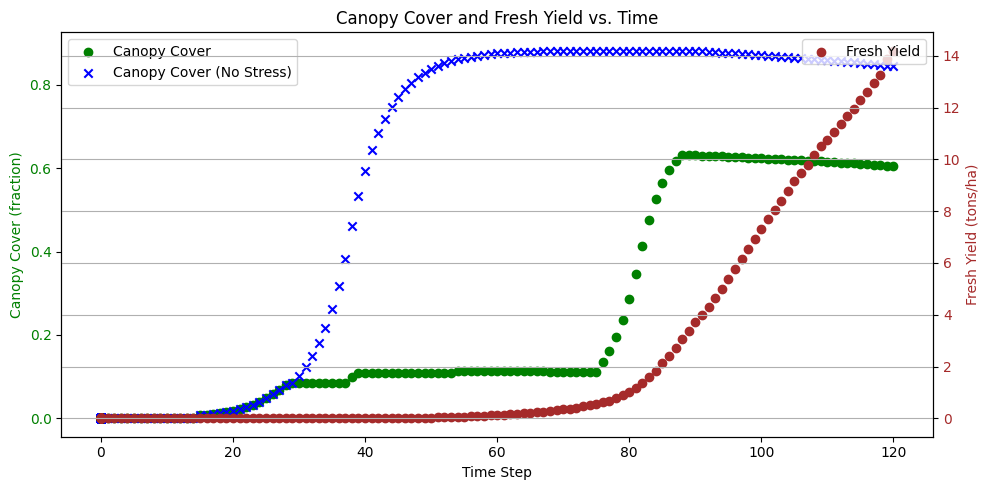

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.scatter(CC['time_step_counter'], CC['canopy_cover'], label='Canopy Cover', color='green')
ax1.scatter(CC['time_step_counter'], CC['canopy_cover_ns'], label='Canopy Cover (No Stress)', color='blue', marker='x')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Canopy Cover (fraction)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.scatter(CC['time_step_counter'], CC['FreshYield'], label='Fresh Yield', color='brown', marker='o')
ax2.set_ylabel('Fresh Yield (tons/ha)', color='brown')
ax2.tick_params(axis='y', labelcolor='brown')

plt.title('Canopy Cover and Fresh Yield vs. Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()



# HUMEDAD DEL SUELO

In [25]:
FLUJOS

time_step_counter  season_counter  dap     Wr  z_gw  surface_storage  \
0                  0.0             0.0  1.0  62.83   NaN              0.0   
1                  1.0             0.0  2.0  60.33   NaN              0.0   
2                  2.0             0.0  3.0  58.58   NaN              0.0   
3                  3.0             0.0  4.0  65.44   NaN              0.0   
4                  4.0             0.0  5.0  62.09   NaN              0.0   
..                 ...             ...  ...    ...   ...              ...   
207                0.0             0.0  0.0   0.00   0.0              0.0   
208                0.0             0.0  0.0   0.00   0.0              0.0   
209                0.0             0.0  0.0   0.00   0.0              0.0   
210                0.0             0.0  0.0   0.00   0.0              0.0   
211                0.0             0.0  0.0   0.00   0.0              0.0   

     IrrDay      Infl  Runoff  DeepPerc   CR  GwIn        Es  EsPot   Tr  \
0       0.0  0.000000     0.0       0.0  0.0   0.0  1.168710  1.265  0.0   
1       0.0  0.000000     0.0       0.0  0.0   0.0  2.497543  3.388  0.0   
2       0.0  0.000000     0.0       0.0  0.0   0.0  1.754721  3.102  0.0   
3       0.0  9.499777     0.0       0.0  0.0   0.0  2.640000  2.640  0.0   
4       0.0  0.000000     0.0       0.0  0.0   0.0  2.992000  2.992  0.0   
..      ...       ...     ...       ...  ...   ...       ...    ...  ...   
207     0.0  0.000000     0.0       0.0  0.0   0.0  0.000000  0.000  0.0   
208     0.0  0.000000     0.0       0.0  0.0   0.0  0.000000  0.000  0.0   
209     0.0  0.000000     0.0       0.0  0.0   0.0  0.000000  0.000  0.0   
210     0.0  0.000000     0.0       0.0  0.0   0.0  0.000000  0.000  0.0   
211     0.0  0.000000     0.0       0.0  0.0   0.0  0.000000  0.000  0.0   

     TrPot  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
..     ...  
207    0.0  
208    0.0  
209    0.0  
210    0.0  
211    0.0  

[212 rows x 16 columns]

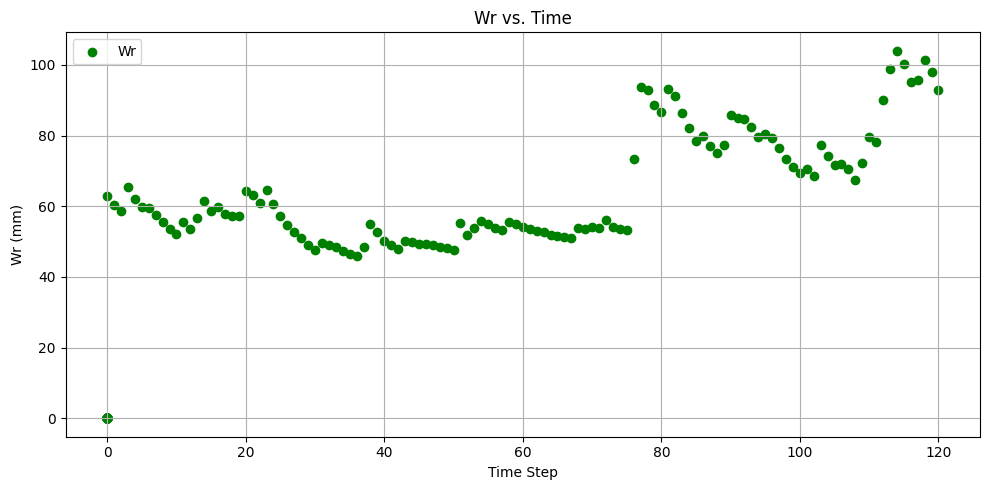

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(FLUJOS['time_step_counter'], FLUJOS['Wr'], label='Wr', color='green')
# plt.scatter(CC['time_step_counter'], CC['Wr'], label='Canopy Cover (No Stress)', color='blue', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Wr (mm)')
plt.title('Wr vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rendimiento

In [27]:
RESUMEN


Season crop Type Harvest Date (YYYY/MM/DD)  Harvest Date (Step)  \
0       0    Potato                2023-01-30                  120   

   Dry yield (tonne/ha)  Fresh yield (tonne/ha)  Yield potential (tonne/ha)  \
0              2.839159               14.195794                    6.958701   

   Seasonal irrigation (mm)  
0                         0

### Rendimientos por tipo de suelo

In [28]:
FRANCO_ARCILLOSO = Soil(soil_type='ClayLoam')
FRANCO = Soil(soil_type='Loam')
FRANCO_ARCILLOSO_ARENOSO = Soil(soil_type='SandyClayLoam')

MI_MODELO_P1_FRANCO_ARCILLOSO = AquaCropModel(
                      sim_start_time='2022/10/01',
                      sim_end_time='2023/4/12',
                      weather_df=weather_data,
                      soil=FRANCO_ARCILLOSO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=fcWC)
MI_MODELO_P1_FRANCO_ARCILLOSO.run_model(till_termination=True)

MI_MODELO_P1_FRANCO = AquaCropModel(
                      sim_start_time='2022/10/01',
                      sim_end_time='2023/4/12',
                      weather_df=weather_data,
                      soil=FRANCO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=fcWC)
MI_MODELO_P1_FRANCO.run_model(till_termination=True)

MI_MODELO_P1_FRANCO_ARCILLOSO_ARENOSO = AquaCropModel(
                      sim_start_time='2022/10/01',
                      sim_end_time='2023/4/12',
                      weather_df=weather_data,
                      soil=FRANCO_ARCILLOSO_ARENOSO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=fcWC)
MI_MODELO_P1_FRANCO_ARCILLOSO_ARENOSO.run_model(till_termination=True)

names=['FRANCO_ARCILLOSO','FRANCO', 'FRANCO_ARCILLOSO_ARENOSO']

dflist=[MI_MODELO_P1_FRANCO_ARCILLOSO._outputs.final_stats,
        MI_MODELO_P1_FRANCO._outputs.final_stats,
        MI_MODELO_P1_FRANCO_ARCILLOSO_ARENOSO._outputs.final_stats,
        ]

outlist=[]
for i in range(len(dflist)):
    temp = pd.DataFrame(dflist[i]['Fresh yield (tonne/ha)'])
    temp['label']=names[i]
    outlist.append(temp)

all_outputs = pd.concat(outlist,axis=0)
all_outputs

Fresh yield (tonne/ha)                     label
0               16.100100          FRANCO_ARCILLOSO
0               18.251412                    FRANCO
0               13.496578  FRANCO_ARCILLOSO_ARENOSO

Text(0, 0.5, 'Rendimiento (ton/ha)')

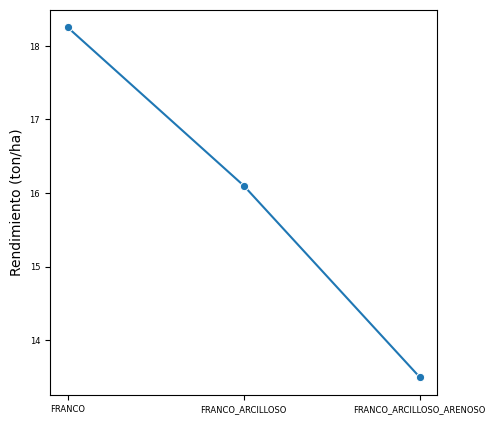

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mean_yield = all_outputs.groupby('label')['Fresh yield (tonne/ha)'].mean().reset_index()
sns.lineplot(data=mean_yield, x='label', y='Fresh yield (tonne/ha)', marker='o', ax=ax)
ax.tick_params(labelsize=6)
ax.set_xlabel(' ')
ax.set_ylabel('Rendimiento (ton/ha)', fontsize=10)




También puedes crear perfiles de contenido inicial de agua (IWC) con múltiples capas aumentando la longitud de las listas depth_layer y value, donde el primer valor se refiere a la primera capa del suelo (la más superficial). Esto es especialmente importante al especificar perfiles de suelo personalizados con múltiples capas: si el número de capas en tu perfil de IWC no coincide con el número de capas en tu perfil de suelo, el IWC de todas las capas del suelo se establecerá en Capacidad de Campo (Field Capacity).

In [30]:
# If you have more than one soil layer, you can specify the initial water content of each layer.
# e.g. for soil profile with two layers, first filled to Field Capacity, second to Wilting Point:
# multiWC =   InitialWaterContent(wc_type = 'Prop',
#                                 method = 'Layer',
#                                 depth_layer= [1,2],
#                                 value = ['FC', 'WP'])

# # Alternatively you could specify two different % TAWs:
# multiTawWC = InitialWaterContent(wc_type = 'Pct',
#                                 method = 'Layer',
#                                 depth_layer= [1,2],
#                                 value = [80, 50])



## Estimación de necesidades de riego en diferentes escenarios

Los parámetros de manejo del riego se seleccionan creando un objeto `IrrigationManagement`. Con esta clase podemos especificar una variedad de estrategias de manejo del riego. Las 6 estrategias diferentes se pueden seleccionar utilizando el argumento  `IrrMethod` al crear la clase. Estas estrategias son las siguientes:


*   `IrrMethod=0`: Rainfed (no irrigation)
*   `IrrMethod=1`: Irrigation is triggered if soil water content drops below a specified threshold (or four thresholds representing four major crop growth stages (emergence, canopy growth, max canopy, senescence).
*   `IrrMethod=2`: Irrigation is triggered every N days
*   `IrrMethod=3`: Predefined irrigation schedule
*   `IrrMethod=4`: Net irrigation (maintain a soil-water level by topping up all compartments daily)
*   `IrrMethod=5`: Constant depth applied each day


The full list of parameters you can edit are:

Variable Name | Type | Description | Default
--- | --- | --- | ---
IrrMethod| `int` | Irrigation method: | 0
 || 0 : rainfed |
 || 1 : soil moisture targets
 || 2 : set time interval |
 || 3: predefined schedule |
 || 4: net irrigation |
 || 5: constant depth |
SMT | `list[float]` | Soil moisture targets (%TAW) to maintain in each growth stage  | [100,100,100,100]
|| (only used if irrigation method is equal to 1) |
IrrInterval  | `int` | Irrigation interval in days | 3
|| (only used if irrigation method is equal to 2) |
Schedule | `pandas.DataFrame` | DataFrame containing dates and depths | None
|| (only used if irrigation method is equal to 3) |
NetIrrSMT | `float` | Net irrigation threshold moisture level (% of TAW that will be maintained) | 80.
|| (only used if irrigation method is equal to 4) |
depth  | `float` | constant depth (mm) to apply on each day | 0.
|| (only used if irrigation method is equal to 5) |
WetSurf | `int` | Soil surface wetted by irrigation (%) | 100
AppEff | `int` |  Irrigation application efficiency (%) | 100
MaxIrr |  `float` | Maximum depth (mm) that can be applied each day | 25
MaxIrrSeason |  `float` | Maximum total irrigation (mm) that can be applied in one season | 10_000




Para los fines de esta demostración, investigaremos los rendimientos y el riego aplicado para un conjunto de umbrales constantes de humedad del suelo. Esto significa que los 4 umbrales de humedad del suelo serán iguales La celda siguiente creará y ejecutará un `AquaCropModel`  para cada estrategia de riego y guardará el resultado final.

In [31]:
numWC = InitialWaterContent(wc_type = 'Prop',
                            method = 'Layer',
                            depth_layer= [1],
                            value = [0.2])

labels=[]

outputs=[]
for smt in range(0,30,5): # UMBRALES DE RIEGO
    labels.append(str(smt))
    irr_mngt = IrrigationManagement(irrigation_method=1,SMT=[smt]*4) # ESTRATEGIAS DE RIEGO 1: UMBRALES
    model = AquaCropModel(sim_start_time='2022/10/01',
                      sim_end_time='2023/04/30',
                      weather_df=weather_data,
                      soil=MI_SUELO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=numWC,
                      irrigation_management=irr_mngt)

    model.run_model(till_termination=True)
    outputs.append(model._outputs.final_stats)


In [32]:
dflist=outputs
labels[0]='Rainfed'
outlist=[]
for i in range(len(dflist)):
    temp = pd.DataFrame(dflist[i][['Fresh yield (tonne/ha)',
                                   'Seasonal irrigation (mm)']])
    temp['label']=labels[i]
    outlist.append(temp)

results=pd.concat(outlist)


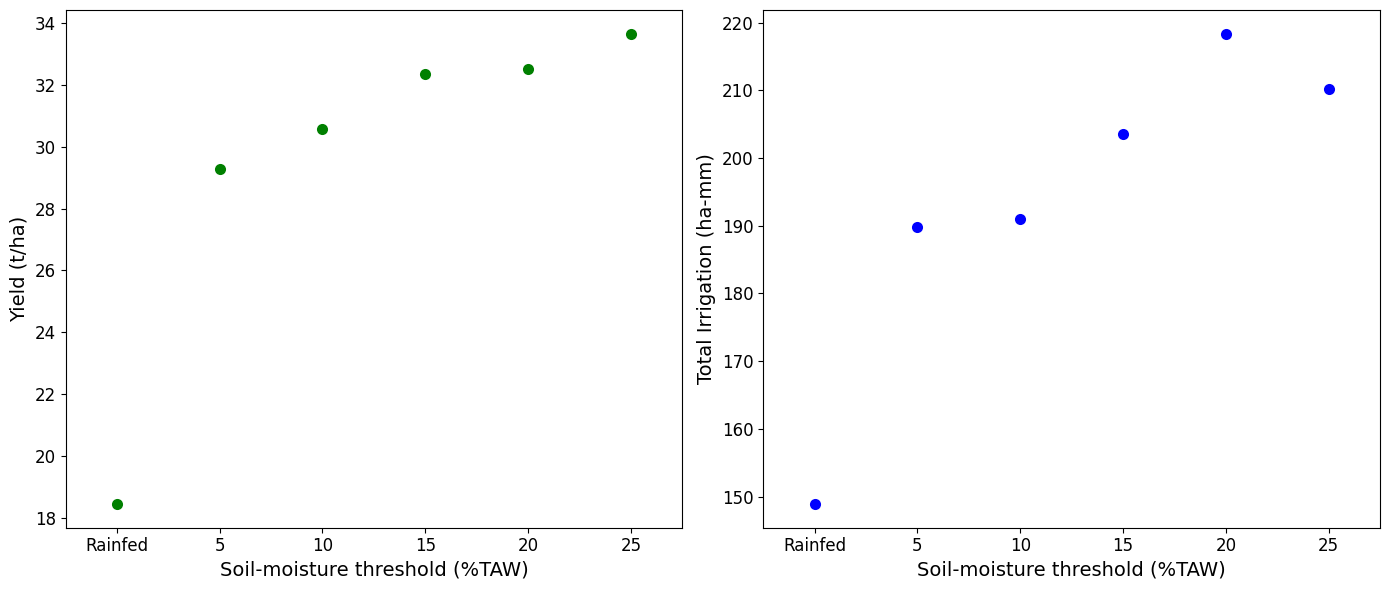

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.stripplot(data=results, x='label', y='Fresh yield (tonne/ha)', ax=ax[0], color='green', size=8)
sns.stripplot(data=results, x='label', y='Seasonal irrigation (mm)', ax=ax[1], color='blue', size=8)

ax[0].tick_params(labelsize=12)
ax[0].set_xlabel('Soil-moisture threshold (%TAW)', fontsize=14)
ax[0].set_ylabel('Yield (t/ha)', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_xlabel('Soil-moisture threshold (%TAW)', fontsize=14)
ax[1].set_ylabel('Total Irrigation (ha-mm)', fontsize=14)

plt.tight_layout()
plt.show()



## PROBANDO CUATRO ESTRATEGIAS DE RIEGO

In [34]:
numWC = InitialWaterContent(wc_type = 'Prop',
                            method = 'Layer',
                            depth_layer= [1],
                            value = [0.2])
labels=[]
outputs_2=[]
for smt in [5,10,15,20]: # INTERVALOS DE RIEGO
    labels.append(str(smt))
    irr_mngt = IrrigationManagement(irrigation_method=2,IrrInterval=smt) # ESTRATEGIAS DE RIEGO 2: INTERVALO FIJO
    model = AquaCropModel(sim_start_time='2022/10/01',
                      sim_end_time='2023/04/30',
                      weather_df=weather_data,
                      soil=MI_SUELO,
                      crop=PAPA_PARCELA_1,
                      initial_water_content=numWC,
                      irrigation_management=irr_mngt)

    model.run_model(till_termination=  1True)
    outputs_2.append(model._outputs.final_stats)


In [35]:
dflist2=outputs_2
outlist2=[]
for i in range(len(dflist2)):
    temp = pd.DataFrame(dflist2[i][['Fresh yield (tonne/ha)',
                                   'Seasonal irrigation (mm)']])
    temp['label']=labels[i]
    outlist2.append(temp)

results2=pd.concat(outlist2)
results2

Fresh yield (tonne/ha)  Seasonal irrigation (mm) label
0               27.069261                235.070118     5
0               13.590334                171.927264    10
0               12.867813                161.860857    15
0                0.000000                 89.624415    20

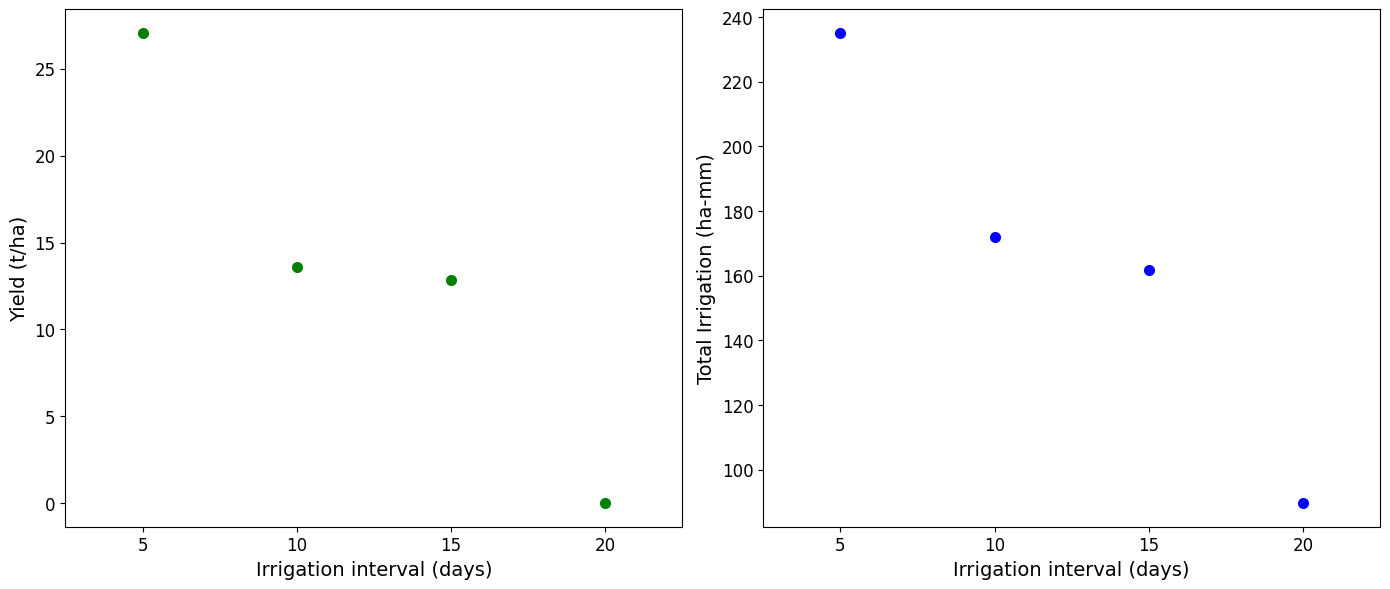

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.stripplot(data=results2, x='label', y='Fresh yield (tonne/ha)', ax=ax[0], color='green', size=8)
sns.stripplot(data=results2, x='label', y='Seasonal irrigation (mm)', ax=ax[1], color='blue', size=8)

ax[0].tick_params(labelsize=12)
ax[0].set_xlabel('Irrigation interval (days)', fontsize=14)
ax[0].set_ylabel('Yield (t/ha)', fontsize=14)

ax[1].tick_params(labelsize=12)
ax[1].set_xlabel('Irrigation interval (days)', fontsize=14)
ax[1].set_ylabel('Total Irrigation (ha-mm)', fontsize=14)

plt.tight_layout()
plt.show()

### EVALUANDO UNA PROGRAMACION DE RIEGO